In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
#import numba
#from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/nfs/dust/cms/user/jschindl/Temp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/04
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
%%time

fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
year = 2016
cat = 2


# path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p7/MC_Summer16/v11/v9/'
path = '/nfs/dust/cms/user/jschindl/rechit_study_per_layer'


bkg_path = path+"/bkg/wH/normalized/"
# greater than one lepton, lepton 27 GeV cut, greater than 2 jets

# fpath_bkg['QCD'] = bkg_path+"QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['DYJetsToLL'] = bkg_path+"DYJetsToLL_M-50_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root"
# fpath_bkg['TTJets_DiLept'] = bkg_path+"TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['TTJets_SingleLeptFromTbar'] = bkg_path+"TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['TTJets_SingleLeptFromT'] = bkg_path+"TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"

# fpath_bkg['WJetsToLNu'] = bkg_path+"WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root"
# fpath_bkg['WJetsToLNu'] = bkg_path+"WJetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['WJetsToLNu_Pt100to250'] = bkg_path+"WJetsToLNu_Pt-100To250_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root"
# fpath_bkg['WJetsToLNu_Pt250to400'] = bkg_path+"WJetsToLNu_Pt-250To400_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root"
# fpath_bkg['WJetsToLNu_Pt600to600'] = bkg_path+"WJetsToLNu_Pt-400To600_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root"
# fpath_bkg['WJetsToLNu_Pt600toInf'] = bkg_path+"WJetsToLNu_Pt-600ToInf_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root"

# fpath_bkg['ZJetsToNuNu'] = bkg_path+"ZJetsToNuNu_Zpt-100toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"

start_t = time.time()

sig_path = path
# fpath_bkg['bbbb10m'] = sig_path + 'WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'
# fpath_bkg['bbbb1m'] = sig_path + 'WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-1000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'
# fpath_bkg['bbbb55'] = sig_path + 'ZH_HToSSTobbbb_ZToLL_MH-125_MS-55_ctauS-1000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'
fpath_bkg['bbbb10m'] = sig_path + '/outfile.root'



# fpath_bkg['bbbb0.1m'] = sig_path + 'WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-100_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'

if year == 2016:lumi = 35.92*1000 #in pb-1
elif year == 2017:lumi = 41.53 * 1000
else: lumi = 59.74 * 1000
    

NEvents = {}


for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 

    tree_bkg[k] = root_dir['ntuples']['llp']
    NEvents[k] = root_dir['ntuples']['NEvents'][1]
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["nGenLL"].array()
    print(len(a))



bbbb10m /nfs/dust/cms/user/jschindl/rechit_study_per_layer/outfile.root
114984
CPU times: user 89 ms, sys: 135 ms, total: 224 ms
Wall time: 383 ms


# legend

In [3]:

legend = {}
legend['bbbb10m'] = 'signal c#tau = 10 m'
legend['bbbb1m'] = 'signal c#tau = 1 m'
legend['bbbb0.1m'] = 'signal c#tau = 0.1 m'

legend['DYJetsToLL'] = 'DYJetsToLL'
legend['WJetsToLNu'] = 'WJetsToLNu'

# Helper Functions

In [4]:
import math
def deltaPhi( phi1,  phi2):

    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
  
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

# Load variables

In [5]:
%%time

JET_PT_CUT = 10
MUON_PT_CUT = 20

nGenLL_inside_DT = {}

nDtRecHits = {}
DtRecHitsStation = {}
DtRecHitsSector = {}
DTRecHitsWheel = {}
DTRecHitSuperLayer = {}
DTRecHitLayer = {}
nDTRecHitsperLayer = {}

nDtSimHits = {}
DtSimHitsStation = {}
DtSimHitsSector = {}
DTSimHitsWheel = {}
DTSimHitSuperLayer = {}
DTSimHitLayer = {}
nDTSimHitsperLayer = {}

GenBquarksvx = {}
GenBquarksvy = {}
GenBquarksvz = {}

# gLLP_csc = {}
# nCscWireDigis = {}
# nCscStripDigis = {}
# nCscSimHits = {}
# nCscRecHits = {}
# nCscRecHits_seg = {}
# cscDetLayer_nCscRecHits = {}
# cscDetLayer_nCscSimHits = {}
# cscDetLayer_nWireDigis = {}
# cscDetLayer_nStripDigis = {}
# cscDetLayer_inME1112 = {}
# cscDetLayer = {}

# cscSimHitsX = {}
# cscSimHitsY = {}
# cscSimHitsZ = {}
# cscRecHitsX = {}
# cscRecHitsY = {}
# cscRecHitsZ = {}
# cscRecHitsDetId = {}


# cscSimHitsDetId = {}
# cscSimHitsParticleType = {}
# cscSimHitsEnergyLoss = {}
# gLLP_decay_vertex_x = {}
# gLLP_decay_vertex_y = {}
# gLLP_decay_vertex_z = {}
# eventNum = {}
# cscDetLayer_maxindex = {}

# nCscWireDigiSimLink = {}
# cscWireDigiSimLinkNWires = {}
# nCscWireOccupancy = {}
# cscWireDigiSimLinkMaxOccupancy = {}


# nCscStripDigiSimLink = {}
# cscStripDigiSimLinkNStrips = {}
# nCscStripOccupancy = {}
# cscStripDigiSimLinkMaxOccupancy = {}
for k,T in tree_bkg.items():
#     # if there's at least one LLP decay in csc
    nGenLL_inside_DT[k] = T.array('nGenLL_inside_DT')
    nDtRecHits[k] = T.array('nDtRecHits')
    DtRecHitsStation[k] = T.array('DtRecHitsStation')
    DtRecHitsSector[k] = T.array('DtRecHitsSector')
    DTRecHitsWheel[k] = T.array('DTRecHitsWheel')
    DTRecHitSuperLayer[k] = T.array('DTRecHitSuperLayer')
    DTRecHitLayer[k] = T.array('DTRecHitLayer')
    nDTRecHitsperLayer[k] = T.array('nDtRecHitsperLayer')

    nDtSimHits[k] = T.array('nDtSimHits')
    DtSimHitsStation[k] = T.array('DtSimHitsStation')
    DtSimHitsSector[k] = T.array('DtSimHitsSector')
    DTSimHitsWheel[k] = T.array('DTSimHitsWheel')
    DTSimHitSuperLayer[k] = T.array('DTSimHitSuperLayer')
    DTSimHitLayer[k] = T.array('DTSimHitLayer')
    nDTSimHitsperLayer[k] = T.array('nDtSimHitsperLayer')
    GenBquarksvx[k] = T.array('GenBquarks.vx')
    GenBquarksvy[k] = T.array('GenBquarks.vy')
    GenBquarksvz[k] = T.array('GenBquarks.vz')
#     gLLP_csc[k] = np.sum(T.array('gLLP_csc'),axis=1)
#     gLLP_decay_vertex_x[k] = T.array('gLLP_decay_vertex_x')
#     gLLP_decay_vertex_y[k] = T.array('gLLP_decay_vertex_y')
#     gLLP_decay_vertex_z[k] = T.array('gLLP_decay_vertex_z')
#     nCscWireDigis[k] = T.array('nCscWireDigis')
#     nCscStripDigis[k] = T.array('nCscStripDigis')
#     nCscSimHits[k] = T.array('nCscSimHits')
#     nCscRecHits[k] = T.array('nCscRecHits')
#     nCscRecHits_seg[k] = T.array('cscSegNRecHits').sum()
#     print(T.array('cscSegNRecHits'))
    
#     cscSimHitsX[k] = T.array('cscSimHitsX')
#     cscSimHitsY[k] = T.array('cscSimHitsY')
#     cscSimHitsZ[k] = T.array('cscSimHitsZ')

#     cscRecHitsX[k] = T.array('cscRecHitsX')
#     cscRecHitsY[k] = T.array('cscRecHitsY')
#     cscRecHitsZ[k] = T.array('cscRecHitsZ')
#     cscRecHitsDetId[k] = T.array('cscRecHitsDetId')
#     cscSimHitsEnergyLoss[k] = T.array('cscSimHitsEnergyLoss').sum()
#     cscSimHitsDetId[k] = T.array('cscSimHitsDetId')
#     cscSimHitsParticleType[k] = T.array('cscSimHitsParticleType')
    
    
#     nCscWireDigiSimLink[k] = T.array('nCscWireDigiSimLink')
#     cscWireDigiSimLinkNWires[k] = T.array('cscWireDigiSimLinkNWires')
#     nCscWireOccupancy[k] = 1.0*nCscWireDigiSimLink[k]/cscWireDigiSimLinkNWires[k]
    
#     nCscStripDigiSimLink[k] = T.array('nCscStripDigiSimLink')
#     cscStripDigiSimLinkNStrips[k] = T.array('cscStripDigiSimLinkNStrips')
#     nCscStripOccupancy[k] = 1.0*nCscStripDigiSimLink[k]/cscStripDigiSimLinkNStrips[k]
    
#     cscWireDigiSimLinkMaxOccupancy[k]  = T.array('cscWireDigiSimLinkOccupancy').max()
#     cscStripDigiSimLinkMaxOccupancy[k]  = T.array('cscStripDigiSimLinkOccupancy').max()


    
# #     nCscDetLayer
#     cscDetLayer_inME1112[k] = T.array('cscDetLayer_inME1112')
#     cscDetLayer_nCscRecHits[k] = T.array('cscDetLayer_nCscRecHits')[np.logical_not(cscDetLayer_inME1112[k])]
#     cscDetLayer_nCscSimHits[k] = T.array('cscDetLayer_nCscSimHits')[np.logical_not(cscDetLayer_inME1112[k])]
#     cscDetLayer_nWireDigis[k] = T.array('cscDetLayer_nWireDigis')[np.logical_not(cscDetLayer_inME1112[k])]
#     cscDetLayer_nStripDigis[k] = T.array('cscDetLayer_nStripDigis')[np.logical_not(cscDetLayer_inME1112[k])]
#     cscDetLayer[k] =  T.array('cscDetLayer')[np.logical_not(cscDetLayer_inME1112[k])]
# #     print( T.array('cscDetLayer_nCscRecHits'))
    
    
#     # to plot simhits distribution
#     eventNum[k] = T.array('eventNum')
#     cscDetLayer_maxindex[k] = cscDetLayer_nCscSimHits[k].argmax()

#     for i,ev in enumerate(eventNum[k]):
#         if len(cscDetLayer_nCscSimHits[k][i]) == 0: continue
#         max_index = np.argmax(cscDetLayer_nCscSimHits[k][i])
        
# #         muons = np.count_nonzero(np.logical_and(np.abs(cscSimHitsParticleType[k][i]) == 13, cscSimHitsDetId[k][i] == cscDetLayer_nCscSimHits[k][i][max_index]))
# #         if muons>0:
#         if cscDetLayer_nCscSimHits[k][i][max_index]<30 and cscDetLayer_nCscSimHits[k][i][max_index]>10 and gLLP_csc[k][i] == 1:
#             print(ev,cscDetLayer[k][i][max_index],cscDetLayer_nCscSimHits[k][i][max_index], cscDetLayer_nCscRecHits[k][i][max_index],nCscSimHits[k][i], nCscRecHits[k][i],gLLP_csc[k][i])


    
    
#     print(cscDetLayer_nCscSimHits[k].max())
#     np.amax(
#         cscDetLayer_nCscSimHits[k].max(), axis = 1)

CPU times: user 4.87 s, sys: 375 ms, total: 5.24 s
Wall time: 5.05 s


# 1D histogram

In [7]:

k = 'bbbb10m'

radius_cut = 100
z_cut = 300


radius = np.sqrt(GenBquarksvx[k].flatten()**2+GenBquarksvy[k].flatten()**2)
radius = radius[::2]
radius = np.array_split(radius,len(nDTSimHitsperLayer[k]))

z = GenBquarksvz[k].flatten()[::2]
z = np.array_split(z,len(nDTSimHitsperLayer[k]))


nGenLL_insideCut = []
for i, event in enumerate(radius):
    tmp = []
    for j, value in enumerate(event):
        if value<radius_cut and abs(z[i][j])<z_cut:
            tmp.append(1)
    if len(tmp)==2:
        nGenLL_insideCut.append(1)
    else:
        nGenLL_insideCut.append(0)
nGenLL_insideCut = np.array(nGenLL_insideCut)


0.027621746063232422


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: bbbb10m (Potential memory leak).
Info in <TCanvas::Print>: pdf file /afs/desy.de/user/j/jschindl/temp_plots/RecHitPlot.pdf has been created


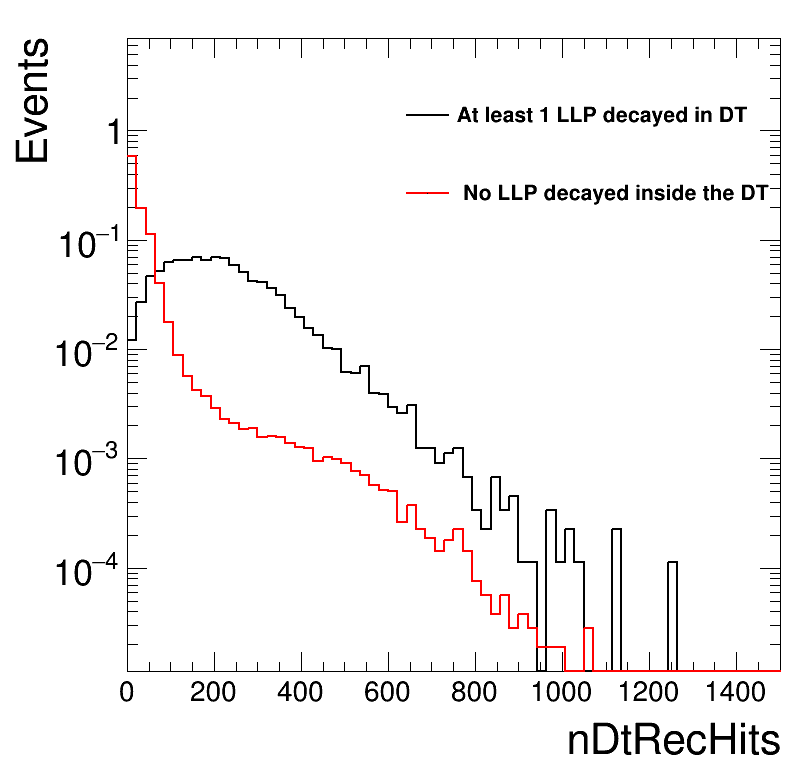

In [17]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.5,0.70,0.80,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
maximum = 0

variables = [nDtSimHits, nDtRecHits]
names = ['nDtSimHits', 'nDtRecHits']
bins = [[75,0,1500],[75,0,1500]]



for i, k in enumerate(tree_bkg.keys()):

    cond = nGenLL_inside_DT[k]
    cond = nDtRecHits[k]*0+cond
    cond = cond.flatten()
    cond_2 = nGenLL_insideCut
    cond_2 = nDtRecHits[k]*0+cond_2
    cond_2 = cond_2.flatten()
#     cond = np.logical_not(gLLP_csc[k])
    #nWireDigis
#     bins = [50,0,800]
#     h[k] = create_TH1D( nCscWireDigis[k][cond], axis_title=['nCscWireDigis', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( nCscWireDigis[k][np.logical_not(cond)], axis_title=['nCscWireDigis', 'Events'], name=k, binning=bins)

#     #nStripDigis
    bins = [70,0,1500]
    h[k] = create_TH1D( nDtRecHits[k][cond >= 1], axis_title=['nDtRecHits', 'Events'], name=k, binning=bins)
    h[k+'not'] = create_TH1D( nDtRecHits[k][cond ==0], axis_title=['nDtRecHits', 'Events'], name=k, binning=bins)
    
    
    #h[k] = create_TH1D( nDTRecHitsperLayer[k].flatten()[cond >= 1], axis_title=['nDtRecHitsperlayer', 'Events'], name=k, binning=bins)
    #h[k+'not'] = create_TH1D( nDTRecHitsperLayer[k].flatten()[cond_2 ==1], axis_title=['nDtRecHitsperlayer', 'Events'], name=k, binning=bins)
#     print(nCscStripDigis[k][np.logical_not(cond)])
    
#     #nSimHits
#     bins = [75,0,4000]
#     h[k] = create_TH1D( nCscSimHits[k][cond], axis_title=['nCscSimHits', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( nCscSimHits[k][np.logical_not(cond)], axis_title=['nCscSimHits', 'Events'], name=k, binning=bins)

#     #nRecHits
#     bins = [75,0,4000]
#     h[k] = create_TH1D( nCscRecHits[k][cond], axis_title=['nCscRecHits', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( nCscRecHits[k][np.logical_not(cond)], axis_title=['nCscRecHits', 'Events'], name=k, binning=bins)
    #     #nRecHits
#     bins = [75,0,500]
#     h[k] = create_TH1D( nCscRecHits_seg[k][cond >=1 ], axis_title=['nCscRecHits', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( nCscRecHits_seg[k][cond == 0], axis_title=['nCscRecHits', 'Events'], name=k, binning=bins)
#     print(nCscRecHits_seg[k])
#     #     #number of rechits per layer
#     bins = [50,0,500]
#     h[k] = create_TH1D( cscSimHitsEnergyLoss[k][cond >=1 ]*10000, axis_title=['Energy loss', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( cscSimHitsEnergyLoss[k][cond == 0]*10000, axis_title=['Energy loss', 'Events'], name=k, binning=bins)
#     print(cscSimHitsEnergyLoss[k])

    
    
#     #number of wiredigis per layer
#     bins = [50,0,100]
#     cond = cscDetLayer_nWireDigis[k]*0+cond
#     cond = cond.flatten()
#     h[k] = create_TH1D( cscDetLayer_nWireDigis[k].flatten()[cond >=1 ], axis_title=['nCscWireDigis per Layer', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( cscDetLayer_nWireDigis[k].flatten()[cond == 0], axis_title=['nCscWireDigis per Layer', 'Events'], name=k, binning=bins)

    #number of stripdigis per layer
#     bins = [50,0,100]
#     cond = cscDetLayer_nStripDigis[k]*0+cond
#     cond = cond.flatten()
#     h[k] = create_TH1D( cscDetLayer_nStripDigis[k].flatten()[cond ==1 ], axis_title=['nCscStripDigis per Layer', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( cscDetLayer_nStripDigis[k].flatten()[cond == 0], axis_title=['nCscStripDigis per Layer', 'Events'], name=k, binning=bins)

#     #number of max wiredigis
#     bins = [50,0,100]
#     h[k] = create_TH1D( cscDetLayer_nWireDigis[k][cond >=1 ], axis_title=['Max WireDigi per Layer', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( cscDetLayer_nWireDigis[k][cond == 0], axis_title=['Max WireDigi per Layer', 'Events'], name=k, binning=bins)

#     #number of max strip
#     bins = [50,0,100]
#     h[k] = create_TH1D( cscDetLayer_nStripDigis[k][cond >=1 ], axis_title=['Max StripDigi per Layer', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( cscDetLayer_nStripDigis[k][cond == 0], axis_title=['Max StripDigi per Layer', 'Events'], name=k, binning=bins)

#     #number of simhits per layer
#     bins = [50,0,800]
# #     cond = cscDetLayer_nCscRecHits[k]*0+cond
# #     cond = cond.flatten()
# #     h[k] = create_TH1D( cscDetLayer_nCscSimHits[k].flatten()[cond >=1 ], axis_title=['nCscSimHits per Layer', 'Events'], name=k, binning=bins)
# #     h[k+'not'] = create_TH1D( cscDetLayer_nCscSimHits[k].flatten()[cond == 0], axis_title=['nCscSimHits per Layer', 'Events'], name=k, binning=bins)
#     h[k] = create_TH1D( cscDetLayer_nCscSimHits[k].max()[cond >=1 ], axis_title=['nCscSimHits per Layer', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( cscDetLayer_nCscSimHits[k].max()[cond == 0], axis_title=['nCscSimHits per Layer', 'Events'], name=k, binning=bins)
#     temp = np.count_nonzero(cscDetLayer_nCscSimHits[k].max()[cond >=1 ]<=100)/len(cscDetLayer_nCscSimHits[k].max()[cond >=1 ])
#     print(temp)
#     #number of rechits per layer
#     bins = [50,0,500]
#     cond = cscDetLayer_nCscRecHits[k]*0+cond
#     cond = cond.flatten()
#     h[k] = create_TH1D( cscDetLayer_nCscRecHits[k].flatten()[cond >=1 ], axis_title=['nCscRecHits per Layer', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( cscDetLayer_nCscRecHits[k].flatten()[cond == 0], axis_title=['nCscRecHits per Layer', 'Events'], name=k, binning=bins)

# #     #number of nCscStripAvgOccupancy
#     bins = [100,0,100]
#     h[k] = create_TH1D( nCscStripOccupancy[k][cond >=1 ], axis_title=['CscStrip Digi Avg Occupancy', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( nCscStripOccupancy[k][cond == 0], axis_title=['CscStrip Digi Avg Occupancy', 'Events'], name=k, binning=bins)

    # #     #number of nCscStripMaxOccupancy
#     bins = [200,0,200]
#     h[k] = create_TH1D( cscStripDigiSimLinkMaxOccupancy[k][cond >=1 ], axis_title=['CscStrip Digi Max Occupancy', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( cscStripDigiSimLinkMaxOccupancy[k][cond == 0], axis_title=['CscStrip Digi Max Occupancy', 'Events'], name=k, binning=bins)




# #     #number of nCscWireOccupancy
#     bins = [30,0,30]
#     h[k] = create_TH1D( nCscWireOccupancy[k][cond >=1 ], axis_title=['CscWire Digi Avg Occupancy', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( nCscWireOccupancy[k][cond == 0], axis_title=['CscWire Digi Avg Occupancy', 'Events'], name=k, binning=bins)


#     # #     #number of nCscWireMaxOccupancy
#     bins = [200,0,200]
#     h[k] = create_TH1D( cscWireDigiSimLinkMaxOccupancy[k][cond >=1 ], axis_title=['CscWire Digi Max Occupancy', 'Events'], name=k, binning=bins)
#     h[k+'not'] = create_TH1D( cscWireDigiSimLinkMaxOccupancy[k][cond == 0], axis_title=['CscWire Digi Max Occupancy', 'Events'], name=k, binning=bins)







    
    
    h[k].SetLineColor(std_color_list[i])
    h[k+'not'].SetLineColor(std_color_list[i+1])


    leg.AddEntry(h[k], 'At least 1 LLP decayed in DT')
    leg.AddEntry(h[k+'not'], ' No LLP decayed inside the DT')
    leg.SetTextSize(0.03)
    h[k].SetMinimum(0.1)
    maximum = max(maximum, h[k].GetMaximum() )
    h[k].SetMaximum(maximum * 100)
    h[k].GetXaxis().SetLabelSize(0.04)
    h[k].DrawNormalized('same hist')
    h[k+'not'].DrawNormalized('same hist')



#     h[k].GetXaxis()


    i+=1
leg.Draw()


# if setlog: 
c.SetLogy()
c.Draw()
c.SaveAs("/afs/desy.de/user/j/jschindl/temp_plots/RecHitPlot.pdf")
print(time.time()-start_t)

# 2D plots per event

0.1691749095916748


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file /afs/desy.de/user/j/jschindl/temp_plots/Plots/2D_Hist_RecHitstudy_per_Layer_cut_2.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file /afs/desy.de/user/j/jschindl/temp_plots/Plots/Profile_RecHitstudy_per_Layer_cut_2.pdf has been created


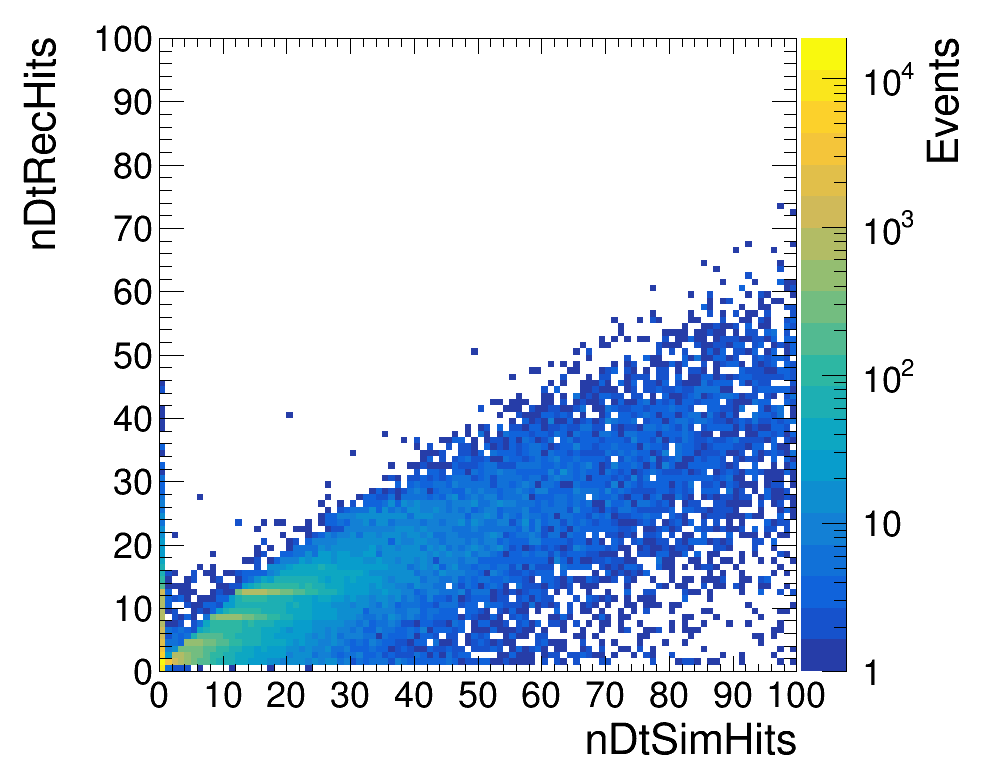

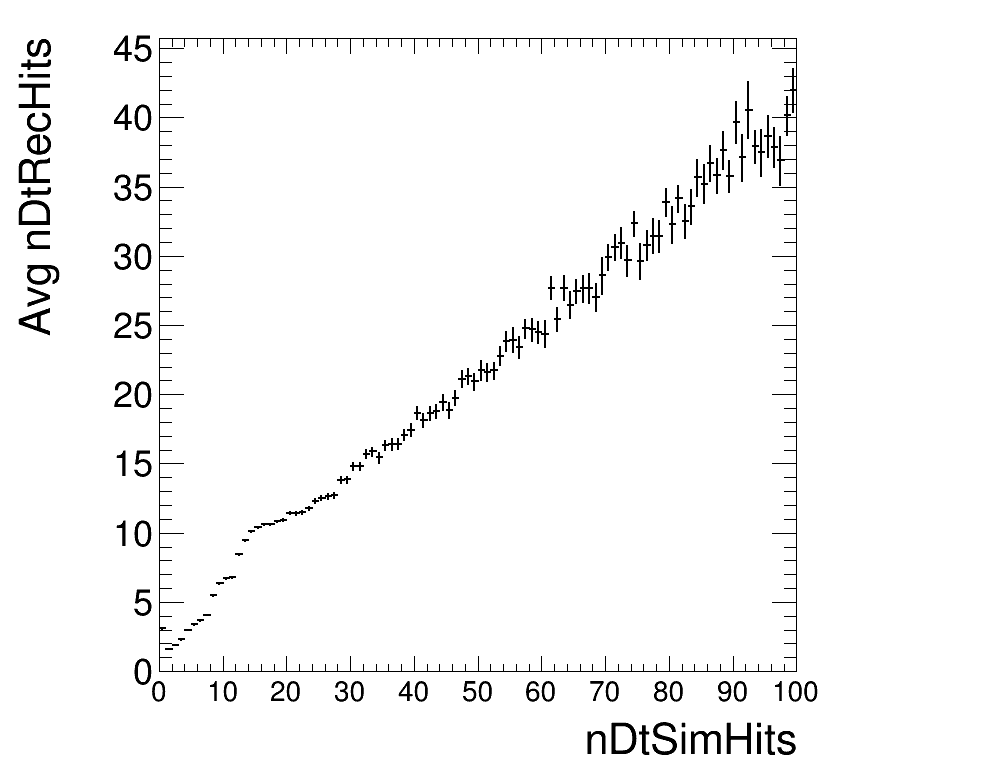

In [10]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k = 'bbbb10m'



cond = nGenLL_inside_DT[k]
#cond = nGenLL_insideCut

cond = nDTSimHitsperLayer[k]*0+cond
cond = cond.flatten()
cond_2 = nGenLL_insideCut
cond_2 = nDTRecHitsperLayer[k]*0+cond_2
cond_2 = cond_2.flatten()


# h[k] = create_TH2D(np.column_stack((nCscWireDigis[k][cond],nCscRecHits[k][cond])), axis_title = ['nWireDigis','nCscRecHits','Events'], binning=[100,0,800,200,0,3000])
# h[k] = create_TH2D(np.column_stack((nCscStripDigis[k][cond],nCscRecHits[k][cond])), axis_title = ['nStripDigis','nCscRecHits','Events'], binning=[100,0,5000,200,0,3000])

# h[k] = create_TH2D(np.column_stack((nCscWireDigis[k][cond],nCscSimHits[k][cond])), axis_title = ['nWireDigis','nCscSimHits','Events'], binning=[100,0,800,250,0,3000])
# h[k] = create_TH2D(np.column_stack((nCscSimHits[k][cond >= 1],nCscStripDigis[k][cond >= 1])), axis_title = ['nCscSimHits','nStripDigis','Events'], binning=[100,0,5000,200,0,3000])

h[k] = create_TH2D(np.column_stack((nDTSimHitsperLayer[k].flatten()[cond >0],nDTRecHitsperLayer[k].flatten()[cond >0])), axis_title = ['nDtSimHits','nDtRecHits','Events'], binning=[100,0,100,100,0,100])
# h[k] = create_TH2D(np.column_stack((cscDetLayer_nCscSimHits[k].flatten()[cond>= 1 ], cscDetLayer_nCscRecHits[k].flatten()[cond >= 1 ])), axis_title = ['nCscSimHits','nCscRecHits','Events'], binning=[150,0,1000,150,0,600])

# h[k] = create_TH2D(np.column_stack((cscDetLayer_nCscSimHits[k].flatten()[cond >= 1 ], cscDetLayer_nWireDigis[k].flatten()[cond >= 1 ])), axis_title = ['nCscSimHits','nCscWireDigis','Events'], binning=[150,0,1000,100,0,100])
# h[k] = create_TH2D(np.column_stack((cscDetLayer_nCscSimHits[k].flatten()[cond >= 1 ], cscDetLayer_nStripDigis[k].flatten()[cond >= 1 ])), axis_title = ['nCscSimHits','nCscStripDigis','Events'], binning=[150,0,1000,100,0,100])



# h[k] = create_TH2D(np.column_stack((nCscRecHits[k][cond],nCscSimHits[k][cond])), axis_title = ['nCscRecHits','nCscSimHits','Events'], binning=[150,0,2000,150,0,2000])



# h[k] = create_TH2D(np.column_stack((nCscStripDigis[k][cond],nCscWireDigis[k][cond])), axis_title = ['nStripDigis','nWireDigis','Events'], binning=[150,0,5000,150,0,800])

h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)

path = '/afs/desy.de/user/j/jschindl/temp_plots'

# if setlog: 
c.SetLogz()
c.Draw()
c.SaveAs(path+"/Plots/2D_Hist_RecHitstudy_per_Layer_cut_2.pdf")

c1 = rt.TCanvas('c1','c1', 1000, 800)
profile = h[k].ProfileX("_pfx",1,-1,"")

#r = profile.Fit('pol1', 'RLSQ+')
#print(r.Get())
#print(r.Prob())
#profile.GetFunction("pol1").SetLineColor(std_color_list[2])
#profile.GetFunction("pol1").SetLineWidth(2)

profile.GetXaxis().SetLabelSize(0.04)
profile.GetYaxis().SetTitle('Avg nDtRecHits')




profile.SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
profile.Draw('colz')
c1.SetRightMargin(0.2)



# if setlog: 
c1.SetLogz()
c1.Draw()
c1.SaveAs(path+"/Plots/Profile_RecHitstudy_per_Layer_cut_2.pdf")

print(time.time()-start_t)


# h[k].Delete()
# Plotting ncsc




In [8]:
#ROC curve
c = rt.TCanvas('c','c', 850, 800)
leg = rt.TLegend(0.5,0.80,0.85,0.90)
leg = rt.TLegend(0.3,0.80,0.55,0.90)


leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}

var = [nCscRecHits_seg, nCscRecHits,]
name =['nCscRecHits_seg', 'nCscRecHits', ]
label = ['nCscRecHits_seg', 'nCscRecHits',]
cond = [gLLP_csc[k]>=1, gLLP_csc[k] == 0]

qcd_key = 'DYJetsToLL'
thre = np.array(range(1000))
k = 'bbbb10m'
for i in range(len(var)):
    eff = {}
    eff['sig'] = []
    eff['bkg'] = []
        
    for th in thre:
        eff['sig'].append(1.0*np.count_nonzero(var[i][k][cond[0]]>th)/len(var[i][k][cond[0]]))
        eff['bkg'].append(1.0*np.count_nonzero(var[i][k][cond[1]]>th)/len(var[i][k][cond[1]]))


    eff['sig'] = np.array(eff['sig'])
    eff['bkg'] = np.array(eff['bkg'])
#     Plotting ROC curve
    eff['sig'] = eff['sig'][np.logical_not(eff['bkg'] <= 0)]
    eff['bkg'] = eff['bkg'][np.logical_not(eff['bkg'] <= 0)]
    print(eff['bkg'].shape, eff['sig'].shape)
#         gr[name[i]+sig_k] = create_TGraph(eff[sig_k],eff[qcd_key],axis_title = ['#epsilon_{sig}','background efficiency'])


    gr[name[i]] = create_TGraph(np.reciprocal(eff['bkg']),eff['sig'],axis_title = ['background rejection','#epsilon_{sig}'])
    gr[name[i]].SetLineColor(std_color_list[i])
    gr[name[i]].SetLineWidth(2)
    gr[name[i]].GetYaxis().SetTitleOffset(1.5)

    gr[name[i]].GetYaxis().SetRangeUser(0,0.2)
#     gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(gr[name[i]],label[i])

    gr[name[i]].Draw('ac' if i==0 else 'c')
    c.SetLeftMargin(0.2)
    leg.Draw()
    value = 0.3 #target signal efficiency
    ind = np.abs(eff['sig']-value).argmin()
#     ind = 110
    print('sig',name[i],1.0/eff['bkg'][ind])
#         print(name[i],eff[sig_k][ind])
    print(thre[ind])

c.SetLogx()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')





NameError: name 'nCscRecHits_seg' is not defined

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


# 2D plots per layer

[ 5 13 63]
[0]
0.2243480682373047


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


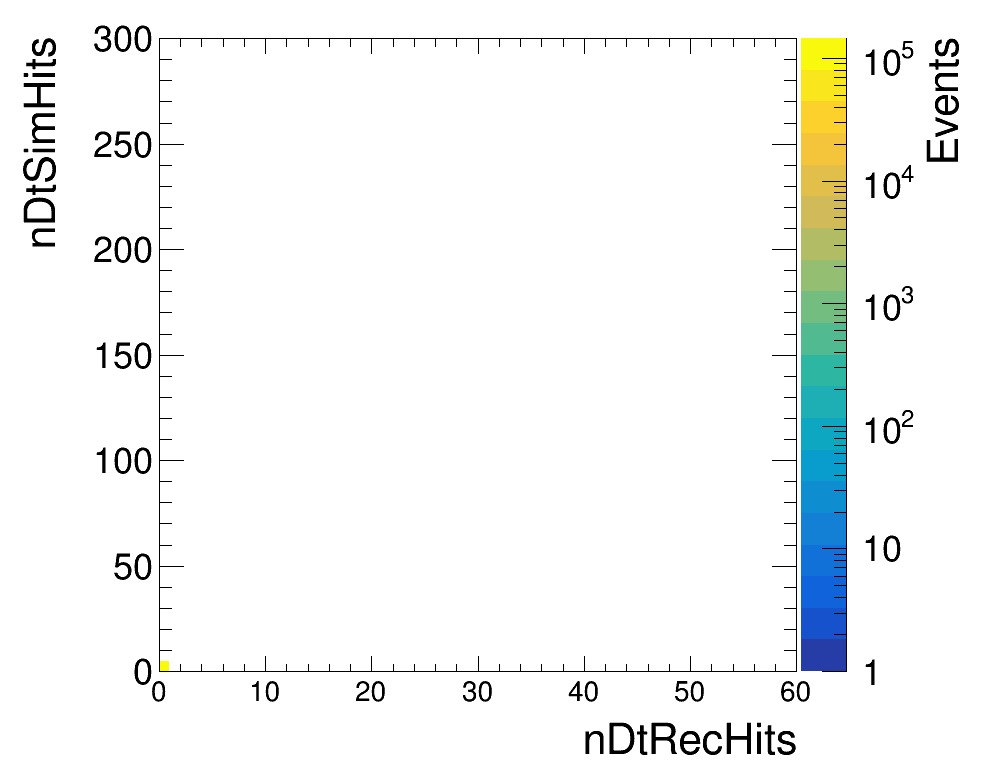

In [57]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

j = 0
k = 'bbbb10m'


# DtRecHitsStation 
# DtRecHitsSector 
# DTRecHitsWheel 
# DTRecHitSuperLayer 


cond = nGenLL_inside_DT[k]
# DTRecHitLayer_Sum = {}
# tmp_array = []
# print(len(DTRecHitLayer[k]))
# for i,array in enumerate(DTRecHitLayer[k]):
#     nRecHitperLayer = 0
#     for j, hiti in enumerate(array):
#         if DtRecHitsStation[k][i][j]== station_to_plot:
#             if DtRecHitsSector[k][i][j]==sector_to_plot:
#                 if DTRecHitsWheel[k][i][j]==wheel_to_plot:
#                     if DTRecHitSuperLayer[k][i][j]==Sl_to_plot:
#                         if hiti==l_to_plot:
#                             nRecHitperLayer+=1
                        
            
#     if i%1000==0:
#         print(i)
#     tmp_array.append(nRecHitperLayer)
# DTRecHitLayer_Sum[k]=np.array(tmp_array)
# print(len(DTSimHitLayer[k]))
# DTSimHitLayer_Sum = {}
# tmp_array = []
# for i,array in enumerate(DTSimHitLayer[k]):
#     nSimHitperLayer = 0
#     for j, hiti in enumerate(array):
#         if DtSimHitsStation[k][i][j]== station_to_plot:
#             if DtSimHitsSector[k][i][j]==sector_to_plot:
#                 if DTSimHitsWheel[k][i][j]==wheel_to_plot:
#                     if DTSimHitSuperLayer[k][i][j]==Sl_to_plot:
#                         if hiti==l_to_plot:
#                             nSimHitperLayer+=1
#     if i%1000==0:
#         print(i)
#     tmp_array.append(nSimHitperLayer)
# DTSimHitLayer_Sum[k]=np.array(tmp_array)

h[k] = create_TH2D(np.column_stack((DTRecHitLayer_Sum[k][cond],DTSimHitLayer_Sum[k][cond])), axis_title = ['nDtRecHits','nDtSimHits','Events'], binning=[60,0,60,60,0,300])


# cond = cscDetLayer_nCscRecHits[k]*0+cond
# cond = cond.flatten()
# cond = (cond == 1)
# print(len(cond),np.count_nonzero(cond))
# print(len(cscDetLayer_nWireDigis[k].flatten()))
# h[k] = create_TH2D(np.column_stack((cscDetLayer_nWireDigis[k].flatten()[cond],cscDetLayer_nCscRecHits[k].flatten()[cond])), axis_title = ['nWireDigis','nCscRecHits','Events'], binning=[100,0,100,100,0,500])

# h[k] = create_TH2D(np.column_stack((cscDetLayer_nStripDigis[k].flatten()[cond],cscDetLayer_nCscRecHits[k].flatten()[cond])), axis_title = ['nStripDigis','nCscRecHits','Events'], binning=[50,0,100,50,0,100])


# h[k] = create_TH2D(np.column_stack((cscDetLayer_nWireDigis[k].flatten()[cond],cscDetLayer_nCscSimHits[k].flatten()[cond])), axis_title = ['nWireDigis','nCscSimHits','Events'], binning=[100,0,100,250,0,1000])
# h[k] = create_TH2D(np.column_stack((nCscStripDigis[k][cond],nCscSimHits[k][cond])), axis_title = ['nStripDigis','nCscSimHits','Events'], binning=[100,0,5000,200,0,3000])

# h[k] = create_TH2D(np.column_stack((cscDetLayer_nCscRecHits[k].flatten()[cond],cscDetLayer_nCscSimHits[k].flatten()[cond])), axis_title = ['nCscRecHits','nCscSimHits','Events'], binning=[150,0,200,150,0,800])



# h[k] = create_TH2D(np.column_stack((nCscStripDigis[k][cond],nCscWireDigis[k][cond])), axis_title = ['nStripDigis','nWireDigis','Events'], binning=[150,0,5000,150,0,800])

h[k].GetXaxis().SetLabelSize(0.04)




h[k].SetLineColor(std_color_list[j])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)



# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)

# SimHit distribution per Layer

20
21
15
19
0
0
[139.24751 137.23349 137.27115 138.99098 138.90771 137.15454 142.48595
 143.86221 149.5309  146.94652 147.00357 148.71863 147.03104 146.97783
 146.92065 133.37749 140.882   141.11513 134.65558 134.87656]
[-530.8045  -531.1113  -530.9534  -528.7419  -528.76105 -526.53644
 -548.13464 -545.5549  -556.1927  -558.4537  -558.67346 -568.353
 -559.07477 -557.6948  -557.789   -522.0904  -546.69196 -546.5215
 -518.37134 -518.3311 ]
[490, -13.0, 11.5, 251, -40.0, 35.5]
141.65947 -541.9418 -922.9681
[[ 2.6142578 13.337219 ]] [[ 39.060913 405.22748 ]] [[ 47.24768 425.5171 ]]
20.0 20 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
CPU times: user 3.57 s, sys: 2.68 s, total: 6.25 s
Wall time: 6.23 s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: bbbb10m (Potential memory leak).


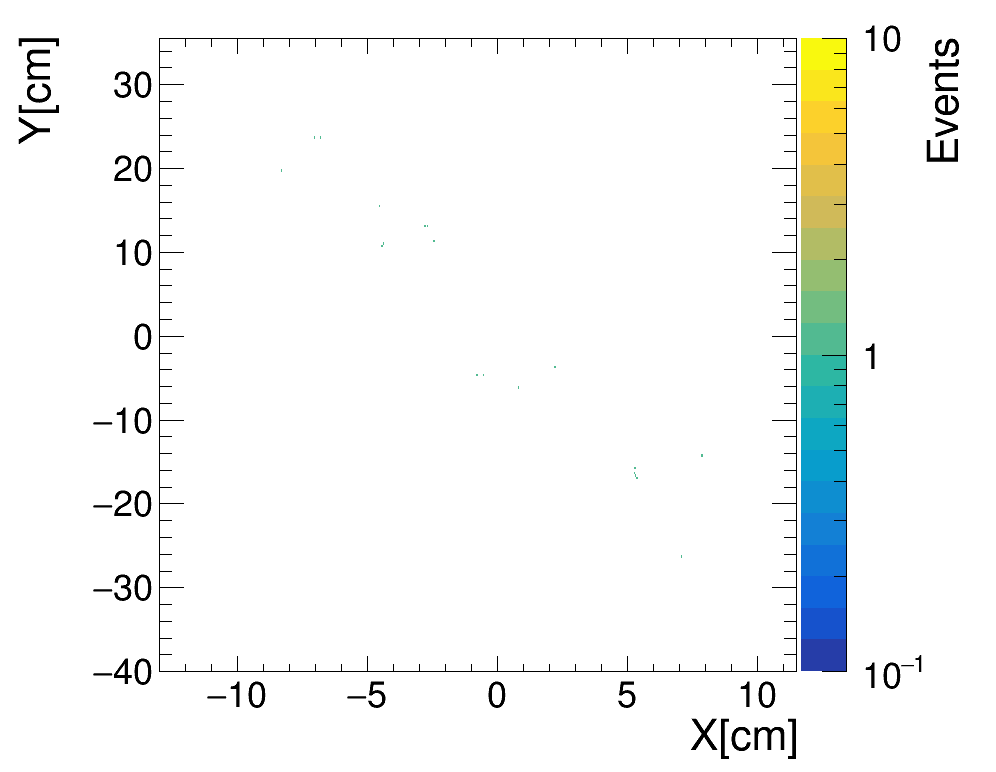

In [58]:
%%time
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

ev = 88785
detid = 604058214
ev = 134356  
detid = 604058858
#   22 12 403 647 1

#   26 20 177 125 1
#   17 0 64 70 1

ev_cond = eventNum[k] == ev
cond = cscSimHitsDetId[k][ev_cond] == detid+1
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid+1][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid+2][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid+3][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid-1][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid-2][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid-3][0]))



meanx = np.mean(cscSimHitsX[k][ev_cond][cond][0])
meany = np.mean(cscSimHitsY[k][ev_cond][cond][0])
meanz = np.mean(cscSimHitsZ[k][ev_cond][cond][0])

print(cscSimHitsX[k][ev_cond][cond][0])
print(cscSimHitsY[k][ev_cond][cond][0])
# print(cscSimHitsParticleType[k][ev_cond][cond][0])
# print(cscSimHitsX[k][ev_cond][cond][0][0]-meanx,cscSimHitsY[k][ev_cond][cond][0][0]-meany)
xmax = int(np.max(cscSimHitsX[k][ev_cond][cond][0])-meanx) * 1.5 +1
xmin = int(np.min(cscSimHitsX[k][ev_cond][cond][0])-meanx) * 1.5 -1
ymax = int(np.max(cscSimHitsY[k][ev_cond][cond][0])-meany) * 1.5 +1
ymin = int(np.min(cscSimHitsY[k][ev_cond][cond][0])-meany) * 1.5 -1
# xmax,xmin,ymax,ymin = 30,-30,20,-20

xnbin = (xmax-xmin)/0.05
ynbin = (ymax-ymin)/0.3
bins = [int(xnbin),xmin,xmax,int(ynbin),ymin,ymax]
print(bins)
print(meanx,meany,meanz)
print(gLLP_decay_vertex_x[k][ev_cond]-meanx, gLLP_decay_vertex_y[k][ev_cond]-meany, gLLP_decay_vertex_z[k][ev_cond]-meanz)
h[k] = create_TH2D(np.column_stack((cscSimHitsX[k][ev_cond][cond][0]-meanx,cscSimHitsY[k][ev_cond][cond][0]-meany)), axis_title = ['X[cm]','Y[cm]','Events'], binning=bins)

h[k].SetMinimum(.1)
h[k].SetMaximum(10)


h[k].Draw('colz')
c.SetLogz()
c.SetRightMargin(0.2)
c.Draw()

ll = []
for i in range(1,h[k].GetNbinsX() + 1):
    for j in range(1,h[k].GetNbinsY() + 1):
        temp = h[k].GetBinContent(i,j)
        if temp > 0:
            ll.append(temp)
print(sum(ll),len(ll),ll)
histo = create_TH1D( ll, axis_title=['nSimHits', 'Events'], name=k, binning=[int(max(ll)),0,int(max(ll))])

[490, -13.0, 11.5, 251, -40.0, 35.5]
141.65947 -541.9418 -922.9681
[[ 2.6142578 13.337219 ]] [[ 39.060913 405.22748 ]] [[ 47.24768 425.5171 ]]
[-78.8824    -76.30316   -74.19941    -7.184723   -1.6389618   2.8841248
  -4.611862    1.0366974   5.6436768  -1.5316925   4.2421417   8.950912 ]
9.0 9 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
CPU times: user 1.3 s, sys: 1.11 s, total: 2.41 s
Wall time: 2.4 s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: bbbb10m (Potential memory leak).


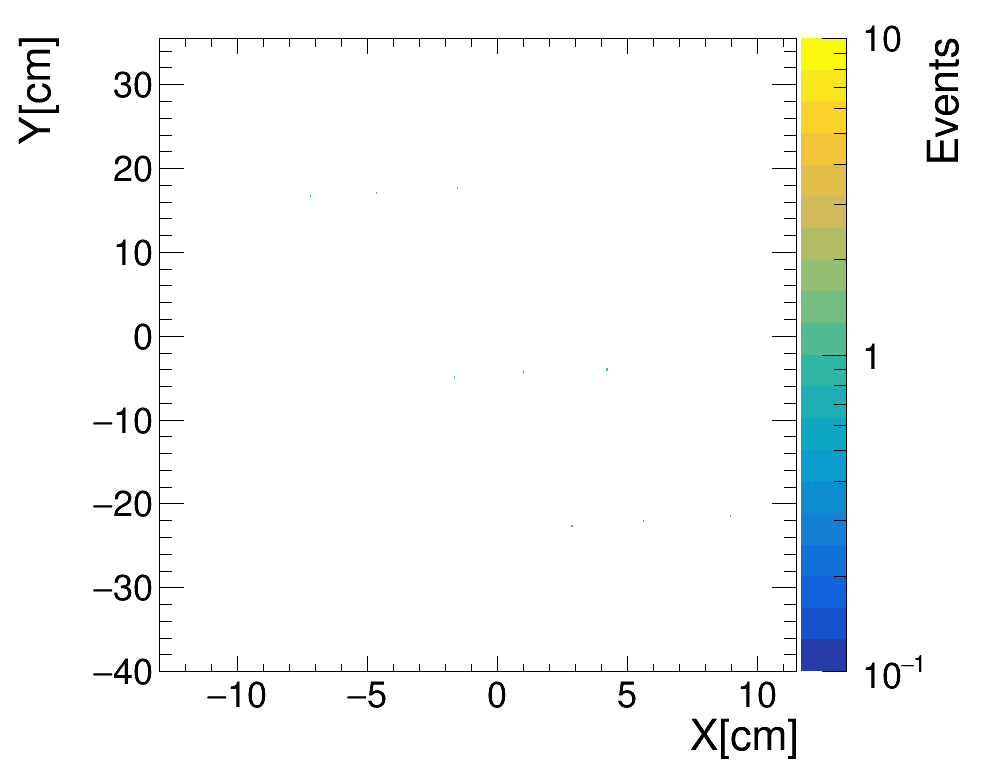

In [59]:
%%time
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

# ev = 17344  
# detid = 604021398

ev_cond = eventNum[k] == ev

cond = cscRecHitsDetId[k][ev_cond] == detid


# meanx = np.mean(cscRecHitsX[k][ev_cond][cond][0])
# meany = np.mean(cscRecHitsY[k][ev_cond][cond][0])
# meanz = np.mean(cscRecHitsZ[k][ev_cond][cond][0])


# print(cscSimHitsParticleType[k][ev_cond][cond][0])
# print(cscSimHitsX[k][ev_cond][cond][0][0]-meanx,cscSimHitsY[k][ev_cond][cond][0][0]-meany)
# xmax = int(np.max(cscRecHitsX[k][ev_cond][cond][0])-meanx) * 1.1
# xmin = int(np.min(cscRecHitsX[k][ev_cond][cond][0])-meanx) * 1.1
# ymax = int(np.max(cscRecHitsY[k][ev_cond][cond][0])-meany) * 1.5 +1
# ymin = int(np.min(cscRecHitsY[k][ev_cond][cond][0])-meany) * 1.5 -1
# xmax,xmin,ymax,ymin = 40,-40,40,-40

# xnbin = (xmax-xmin)
# ynbin = (ymax-ymin)
# bins = [int(xnbin),xmin,xmax,int(ynbin),ymin,ymax]
print(bins)
print(meanx,meany,meanz)
print(gLLP_decay_vertex_x[k][ev_cond]-meanx, gLLP_decay_vertex_y[k][ev_cond]-meany, gLLP_decay_vertex_z[k][ev_cond]-meanz)
h[k] = create_TH2D(np.column_stack((cscRecHitsX[k][ev_cond][cond][0]-meanx,cscRecHitsY[k][ev_cond][cond][0]-meany)), axis_title = ['X[cm]','Y[cm]','Events'], binning=bins)
print(cscRecHitsX[k][ev_cond][cond][0]-meanx)
h[k].SetMinimum(.1)
h[k].SetMaximum(10)


h[k].Draw('colz')
c.SetLogz()
c.SetRightMargin(0.2)
# rt.enableJSVis()
c.Draw()

ll = []
for i in range(1,h[k].GetNbinsX() + 1):
    for j in range(1,h[k].GetNbinsY() + 1):
        temp = h[k].GetBinContent(i,j)
        if temp > 0:
            ll.append(temp)
print(sum(ll),len(ll),ll)
histo = create_TH1D( ll, axis_title=['nSimHits', 'Events'], name=k, binning=[int(max(ll)),0,int(max(ll))])

# Occupancy plot

CPU times: user 470 µs, sys: 0 ns, total: 470 µs
Wall time: 479 µs


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


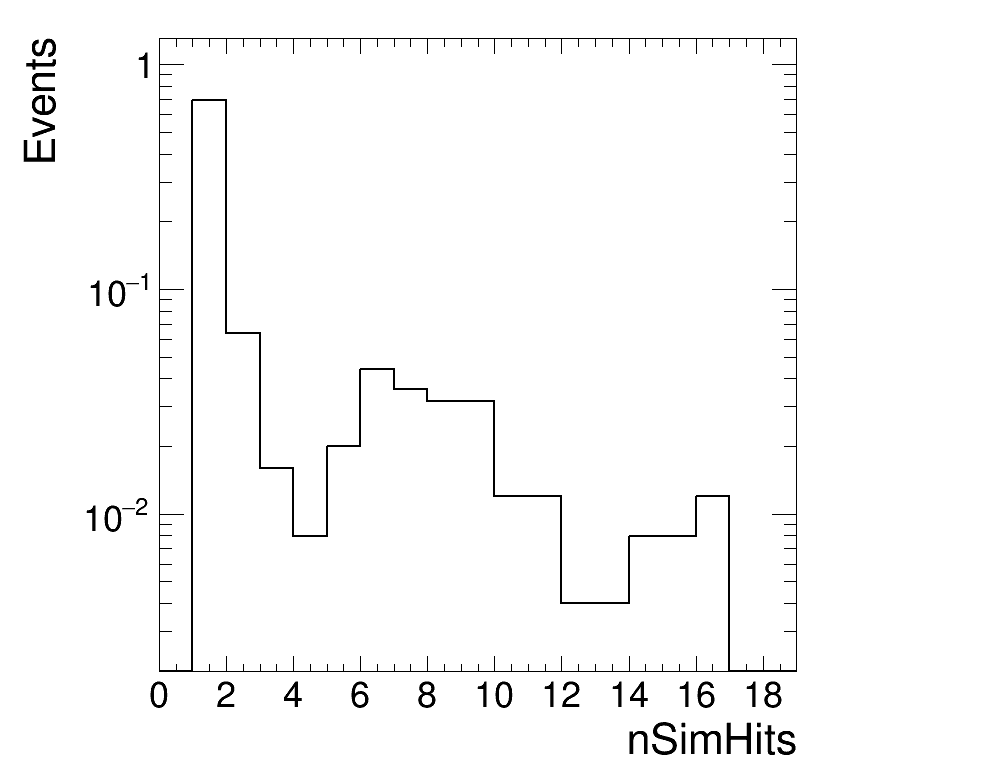

In [53]:
%%time
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)




histo.DrawNormalized('')
c.SetLogy()
c.SetRightMargin(0.2)
# rt.enableJSVis()
c.Draw()



# Occupancy per event

In [ ]:
avg_occupancy = []
max_occupancy = []
for i in range(len(eventNum[k])):
    if len(cscDetLayer_nCscSimHits[k][i]) == 0: continue
    max_index = np.argmax(cscDetLayer_nCscSimHits[k][i])

#     if cscDetLayer_nCscSimHits[k][i][max_index]>750 and gLLP_csc[k][i] == 1:
#         print(ev,cscDetLayer[k][i][max_index],cscDetLayer_nCscSimHits[k][i][max_index], nCscSimHits[k][i], gLLP_csc[k][i])

    cond = cscSimHitsDetId[k][ev_cond] == detid
    meanx = np.mean(cscSimHitsX[k][ev_cond][cond][0])
    meany = np.mean(cscSimHitsY[k][ev_cond][cond][0])
    meanz = np.mean(cscSimHitsZ[k][ev_cond][cond][0])

    xmax = int(np.max(cscSimHitsX[k][ev_cond][cond][0])-meanx) * 1.1
    xmin = int(np.min(cscSimHitsX[k][ev_cond][cond][0])-meanx) * 1.1
    ymax = int(np.max(cscSimHitsY[k][ev_cond][cond][0])-meany) * 1.5 +1
    ymin = int(np.min(cscSimHitsY[k][ev_cond][cond][0])-meany) * 1.5 -1
    # xmax,xmin,ymax,ymin = 20,-20,20,-20

    xnbin = (xmax-xmin)/0.05
    ynbin = (ymax-ymin)/0.3
    bins = [int(xnbin),xmin,xmax,int(ynbin),ymin,ymax]
#     print(bins)
#     print(meanx,meany,meanz)
#     print(gLLP_decay_vertex_x[k][ev_cond]-meanx, gLLP_decay_vertex_y[k][ev_cond]-meany, gLLP_decay_vertex_z[k][ev_cond]-meanz)
    h[k] = create_TH2D(np.column_stack((cscSimHitsX[k][ev_cond][cond][0]-meanx,cscSimHitsY[k][ev_cond][cond][0]-meany)), axis_title = ['X[cm]','Y[cm]','Events'], binning=bins)
    # print(cscSimHitsY[k][ev_cond][cond][0])


    ll = []
    for i in range(1,h[k].GetNbinsX() + 1):
        for j in range(1,h[k].GetNbinsY() + 1):
            temp = h[k].GetBinContent(i,j)
            if temp > 0:
                ll.append(temp)
    print(sum(ll),ll)
    histo = create_TH1D( ll, axis_title=['nSimHits', 'Events'], name=k, binning=[int(max(ll)),0,int(max(ll))])

# significance